# Versuch 2

Ich versuche jetzt ein Transformer-decoder only zu Trainieren, darauf trainiert wird immer nur ein Token basierend auf einer vorhergehenden sequenz vorherzusagen

bin mir noch nicht ganz sicher, ob alles passt mit der Architektur

- bin mir nicht sicher, ob Casual mask und Padding mask funktionieren


Idee:
- Transformer soll auf einer Eingabesquenz nur ein nächstes Token vorhersagen.
    - Bei Inferenz wird dann das ausgegeben token wieder an den input hinten drangehängt
    - So lange machen, bis gewünschte sequenz erreicht ist
- Daten:
    - Bei Training wird als input die Rechte und linke hand genommen
    - Loss wird dann auf den nächsten token von nur der rechten Hand berechnet
    - Modell soll quasi aus bisher gespielter Melodie + Harmony das nächste harmony-token vorhersagen.
    - Sequenzen sind fast immer gleich lang

# 0 import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from data_preperation import dataset_snapshot

import math
import numpy as np

import random

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1 Data preperation

special start token

In [3]:
# Define SOS token as global variables
SOS_TOKEN = np.full((1, 88), 1)  # SOS token representation with ones (adjust for feature dimension)

load datatset

In [4]:
# Create snapshots
dataset_as_snapshots = dataset_snapshot.process_dataset_multithreaded("/home/falaxdb/Repos/minus1/datasets/maestro_v3_split/hands_split_into_seperate_midis", 0.1, amount=10)
# filter snapshots to 88 piano notes
dataset_as_snapshots = dataset_snapshot.filter_piano_range(dataset_as_snapshots)
# compress data into one octave
# dataset_as_snapshots =  dataset_snapshot.compress_existing_dataset_to_12keys(dataset_as_snapshots)

for song in dataset_as_snapshots:
    print("song:")
    for track in song:
        print(track.shape)

Processed dataset (20/20): 100%|██████████| 20/20 [00:00<00:00, 28.01it/s]

Processed 20 of 20 files
song:
(1083, 88)
(1083, 88)
song:
(752, 88)
(752, 88)
song:
(2220, 88)
(2220, 88)
song:
(2730, 88)
(2730, 88)
song:
(3707, 88)
(3707, 88)
song:
(2981, 88)
(2981, 88)
song:
(3805, 88)
(3805, 88)
song:
(3464, 88)
(3464, 88)
song:
(7862, 88)
(7862, 88)
song:
(14334, 88)
(14334, 88)


batchen, splitten, etc

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.optim import Adam



# Function to add SOS token at the start of each song and create sequences
# inputs are right and left hand combined, target is the one snapshot of the left hand
def create_sequences_with_sos(data, seq_length):
    inputs = []
    targets = []
    for song in data: 
        right_h = song[0]
        left_h = song[1]
        
        assert right_h.shape == left_h.shape, "Tracks must have same dimensions"
        
        combined_tracks = np.bitwise_xor(right_h, left_h)
        
        combined_tracks = np.vstack((sos_token, combined_tracks))
        
        for i in range(len(right_h) - seq_length):
            inputs.append(combined_tracks[i:i + seq_length])
            targets.append(left_h[i + seq_length])
    return np.array(inputs), np.array(targets)



# Dataset class
class PianoDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return {
            'input_seq': torch.tensor(input_seq, dtype=torch.float32),
            'target_seq': torch.tensor(target_seq, dtype=torch.float32)
        }



# Collate function to handle padding and creating attention masks
def collate_fn(batch):
    inputs = [item['input_seq'] for item in batch]
    targets = [item['target_seq'] for item in batch]
    
    # Pad sequences to the same length in the batch dimension
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=padding_value)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=padding_value)
    
    # Create the attention mask
    # inputs_padded: (batch_size, max_seq_length, feature_dim)
    attention_mask = (inputs_padded != padding_value).float()
    
    # Reduce attention_mask to (batch_size, max_seq_length) by checking any padding in the feature_dim dimension
    attention_mask = attention_mask.any(dim=-1).float()
    
    return {
        'input_seq': inputs_padded,
        'target_seq': targets_padded,
        'attention_mask': attention_mask
    }


    

In [6]:
sos_token = SOS_TOKEN
padding_value = -1  # Use -1 for padding

# Parameters
seq_length = 100  # Example sequence length

# Split the dataset using sklearn while maintaining pairs
train_data, temp_data = train_test_split(dataset_as_snapshots, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Create sequences for right and left hand data with SOS token
train_inputs, train_targets = create_sequences_with_sos(train_data, seq_length)
val_inputs, val_targets = create_sequences_with_sos(val_data, seq_length)
test_inputs, test_targets = create_sequences_with_sos(test_data, seq_length)

# Create the dataset
train_dataset = PianoDataset(train_inputs, train_targets)
val_dataset = PianoDataset(val_inputs, val_targets)
test_dataset = PianoDataset(test_inputs, test_targets)

# Create DataLoader with collate_fn
batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1

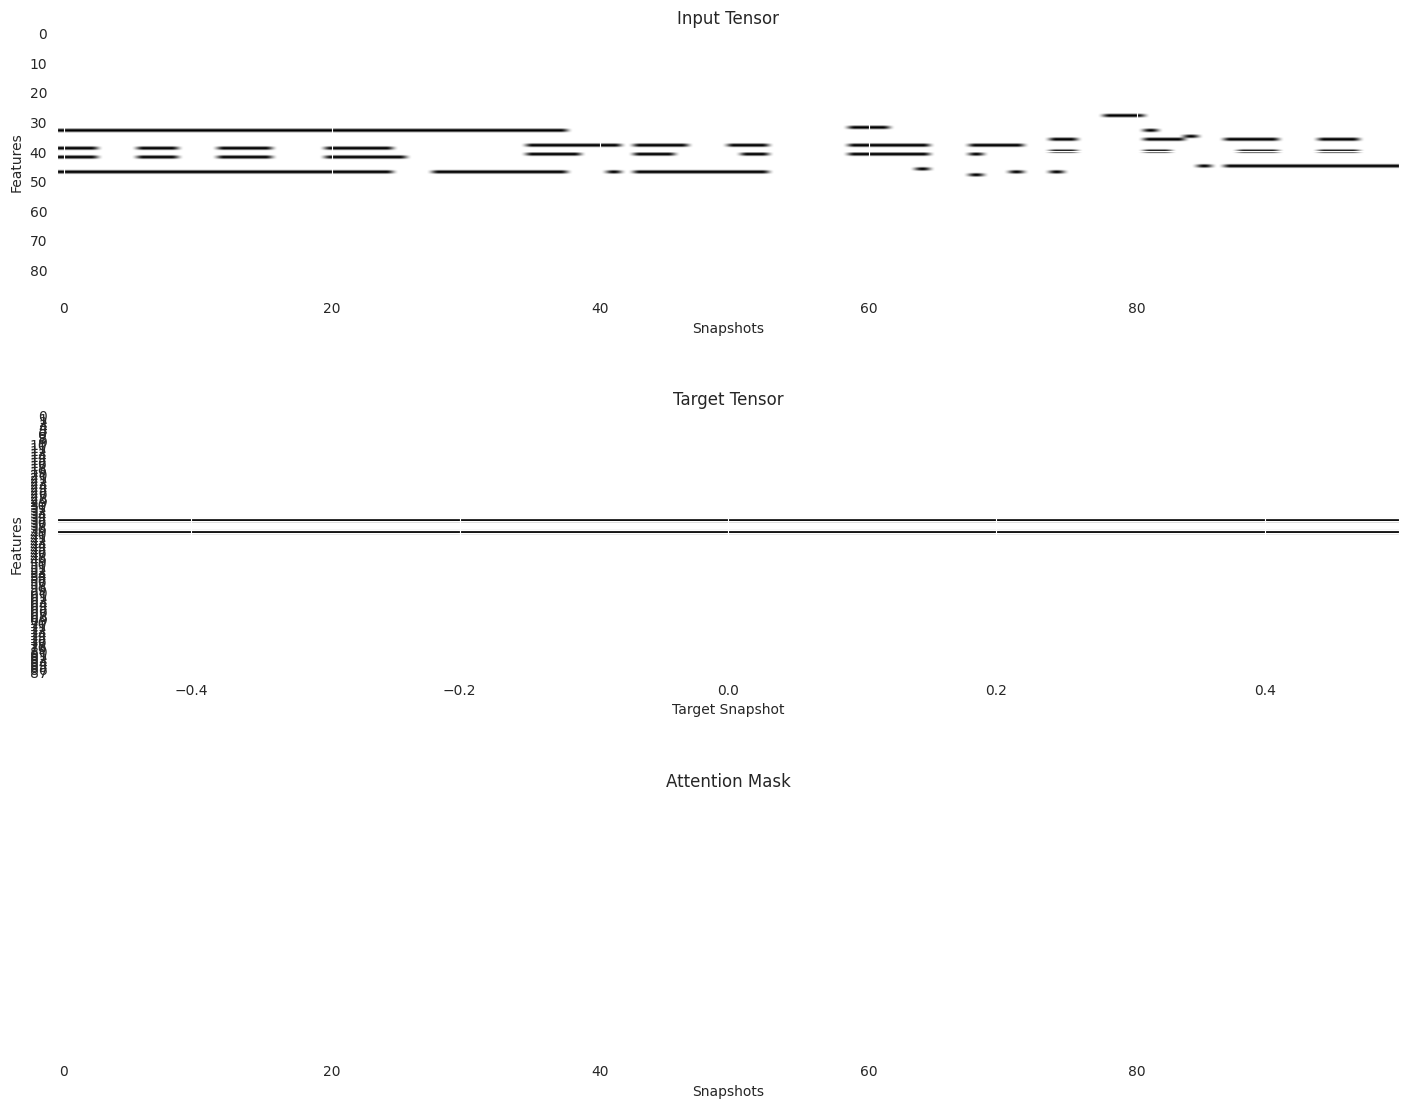

In [7]:
import matplotlib.pyplot as plt

def visualize_tensors(input_tensor, target_tensor, attention_mask):
    """
    Visualizes the input tensor, target tensor, and attention mask.
    
    Parameters:
    - input_tensor: torch.Tensor of shape (seq_length, feature_dim)
    - target_tensor: torch.Tensor of shape (feature_dim)
    - attention_mask: torch.Tensor of shape (seq_length)
    """
    input_np = input_tensor.numpy().T  # Transpose to get features on the y-axis
    target_np = target_tensor.numpy()
    attention_mask_np = attention_mask.numpy()
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    axes[0].imshow(input_np, cmap='binary', aspect='auto')
    axes[0].set_title('Input Tensor')
    axes[0].set_xlabel('Snapshots')
    axes[0].set_ylabel('Features')
    
    axes[1].imshow(target_np.reshape(-1, 1), cmap='binary', aspect='auto')
    axes[1].set_title('Target Tensor')
    axes[1].set_xlabel('Target Snapshot')
    axes[1].set_yticks(np.arange(target_np.shape[0]))
    axes[1].set_yticklabels(np.arange(target_np.shape[0]))
    axes[1].set_ylabel('Features')
    
    axes[2].imshow(attention_mask_np.reshape(1, -1), cmap='binary', aspect='auto')
    axes[2].set_title('Attention Mask')
    axes[2].set_xlabel('Snapshots')
    axes[2].set_yticks([])  # Hide y-axis

    plt.tight_layout(pad=4.0)
    plt.show()

# Get a batch of data
batch = next(iter(train_loader))

# Extract the first example from the batch
input_tensor = batch['input_seq'][0]
target_tensor = batch['target_seq'][0]
attention_mask = batch['attention_mask'][0]

print(input_tensor)
print(target_tensor)
print(attention_mask)

# Visualize the example
visualize_tensors(input_tensor, target_tensor, attention_mask)

# 2 Define model

positional and mask

In [8]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Info
        self.dropout = nn.Dropout(p=dropout)
        
        # Encoding - From formula -> This is basically applying the formula for Positional encoding (The one with Sinus and Cosinus)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Baically a positions list 0, 1, 2, 3, 4, 5, ...
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 1000^(2i/dim_model)
        
        # # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        
        #  # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pe[:, 1::2] = torch.cos(position * div_term)
        
         # Saving buffer (same as parameter without gradients needed)
        # pe = pe.unsqueeze(0).transpose(0, 1)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (1, max_len, d_model) Änderung evtl. wegen batch first = True
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        # Residual connection + pos encoding
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]
    
    return mask

# Die Funktion create_mask erstellt sowohl Quell- als auch Ziel-Pad-Masken, indem sie prüft, ob Elemente in der Quell- und Zielsequenz gleich dem Pad-Token sind. Diese Masken werden transponiert, um die richtige Dimension zu erhalten.
def create_mask(tgt):
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    return tgt_mask

Transformer

In [9]:
class TransformerDecoderModel(nn.Module):
    def __init__(self, input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout=0.1, max_len=5000):
        super(TransformerDecoderModel, self).__init__()
        self.model_type = 'Transformer'
        
        # Hier werden die Layers des modells definiert
        
        # Input token werden zu embedding vektoren umgewandelt -> hier einfach mit linearer schicht
        # input dimension wird zu embed_dim transformiert. embed dim ist die dimension meiner embeddings
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional encoding schicht für infos zu reihenfolge
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        
        # hier werden die Decoder layers und der stack an layers (der transformer definiert)
        decoder_layers = nn.TransformerDecoderLayer(embed_dim, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)
        
        # output schicht, um die wahrscheinlichkeit für die features
        self.generator = nn.Linear(embed_dim, input_dim)
        
        # Sigmoid für zwischen 0 und 1 
        self.sigmoid = nn.Sigmoid()

    def forward(self, src, attention_mask, tgt_mask=None):
        tgt = self.embedding(src)
        tgt = self.pos_encoder(tgt)  # Apply positional encoding
        
        src_key_padding_mask = attention_mask == 0
        
        output = self.transformer_decoder(tgt, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=src_key_padding_mask)
        output = self.generator(output)
        
        output = self.sigmoid(output[:, -1, :])
        return output

# 3 train model

In [10]:
# Hyperparameters
input_dim = 88 # Dimension der eingehenden tokens
embed_dim = 128  # Embedding dimension
nhead = 4 # anzahl der attention heads
num_decoder_layers = 3 # anzahl der decoder layer (die Blöcke übereinander)
dim_feedforward = 128 # dimension des feedforward neural nets
dropout = 0.1
# batch_size = 32 oben festgelegt
num_epochs = 10
learning_rate = 0.001
max_len = 200  # Maximum length of the sequences -> abbruch ohne end token

In [11]:
# Modell initialisieren
model = TransformerDecoderModel(input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout, max_len)
# auf GPU laden
model = model.to(DEVICE)

# Kostenfunktion festlegen 
loss_fn = nn.BCELoss()

# optimizer festlegen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training

In [12]:
def debug_shapes_and_ranges(X, y, output):
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Output shape:", output.shape)
    print("Output range:", torch.min(output).item(), torch.max(output).item())
    print("y range:", torch.min(y).item(), torch.max(y).item())

def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        # Move data to GPU
        input_seq = batch['input_seq'].to(DEVICE)
        target_seq = batch['target_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        
        # Get mask to mask out the next words
        tgt_mask = create_mask(input_seq).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(input_seq, attention_mask, tgt_mask=tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        # Debug shapes and ranges
        # debug_shapes_and_ranges(X, y, logits)
        print("logits_shape:", logits.shape)
        # Calculate the loss
        loss = loss_fn(logits, target_seq)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    total_loss = 0
    
    for batch in dataloader:
        # Move data to GPU
        input_seq = batch['input_seq'].to(DEVICE)
        target_seq = batch['target_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        
        # Get mask to mask out the next words
        tgt_mask = create_mask(input_seq).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(input_seq, attention_mask, tgt_mask=tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        # Debug shapes and ranges
        # debug_shapes_and_ranges(X, y, logits)
        
        # Calculate the loss
        loss = loss_fn(logits, target_seq)
        
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [13]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_loop(model, optimizer, loss_fn, train_loader)
    end_time = timer()
    val_loss = validation_loop(model, loss_fn, val_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

/home/falaxdb/Repos/minus1/venv/lib64/python3.12/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.Size([32, 88])
logits_shape: torch.

KeyboardInterrupt: 

# 4 Inferenz

In [ ]:
def generate_sequence(model, input_seq, attention_mask, seq_length, device):
    """
    Generate a sequence of predictions using the transformer model.

    Parameters:
    - model: Trained transformer model
    - input_seq: Initial input sequence (tensor of shape (1, seq_length, feature_dim))
    - attention_mask: Attention mask for the input sequence
    - seq_length: Length of the sequence to generate
    - device: Device to perform inference on

    Returns:
    - generated_seq: Generated sequence of predictions (tensor of shape (generated_length, feature_dim))
    """
    model.eval()  # Set the model to evaluation mode
    generated_seq = []
    
    
    with torch.no_grad():
        for i in range(seq_length):
            # Generate target mask for the current sequence length
            tgt_mask = generate_square_subsequent_mask(input_seq.size(1)).to(device)
            
            print(f"Input step {i}:", input_seq.shape)
            
            # Forward pass
            output = model(input_seq, attention_mask, tgt_mask=tgt_mask)
            # Get the prediction for the last time step
            next_token = output
            

            # Append the prediction to the generated sequence
            generated_seq.append(next_token)

            # Update the input sequence to include the new prediction
            input_seq = torch.cat((input_seq, next_token.unsqueeze(1)), dim=1)

            # Update the attention mask accordingly
            new_mask = torch.ones(1, 1, device=device)
            attention_mask = torch.cat((attention_mask, new_mask), dim=1)

    generated_seq = torch.cat(generated_seq, dim=0)
    return generated_seq

In [ ]:
def inference_single(model, test_loader, device, seq_length):
    # Get the first batch from the test loader
    for batch in test_loader:
        input_seq = batch['input_seq'][0:1].to(device)  # Get the first sequence and keep batch dimension
        attention_mask = batch['attention_mask'][0:1].to(device)  # Get the attention mask for the first sequence
        break

    print(attention_mask.shape)

    # Generate sequence
    generated_sequence = generate_sequence(model, input_seq, attention_mask, seq_length, device)
    return generated_sequence

generated_sequence = inference_single(model, test_loader, DEVICE, 100)

print(generated_sequence.shape)

# 5 output analysieren

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import os

def printHeatmap(predicted_harmony, center=0.1, vmin=0, vmax=1):
    # Create the 'pictures' directory if it doesn't exist
    if not os.path.exists('pictures'):
        os.makedirs('pictures')

    # Determine the next prefix number for saving files
    existing_files = [f for f in os.listdir('pictures') if f.endswith('.png')]
    if existing_files:
        latest_file = max(existing_files)
        latest_prefix = int(latest_file.split('_')[0])
        prefix = f"{latest_prefix + 1:02d}_"
    else:
        prefix = "00_"

    # Create and save a heatmap of Predicted Harmony Data
    plt.figure(figsize=(20, 10))  # Adjust the size as necessary
    sns.heatmap(predicted_harmony, cmap='coolwarm', center=center, vmin=vmin, vmax=vmax)  # Adjust color map and limits based on your data
    plt.title('Heatmap of Predicted Harmony Data')
    plt.xlabel('Keys on piano')
    plt.ylabel('Probability of pressing (One-Hot-Encoding)')
    plt.savefig(os.path.join('pictures', f'{prefix}heatmap_predicted_harmony.png'))
    plt.show()

In [ ]:
threshold = 0.08

output_sequence = generated_sequence

print(output_sequence.shape)
print("Output range:", torch.min(output_sequence).item(), torch.max(output_sequence).item())

# apply threshold value
# Apply thresholding
#output_sequence = (output_sequence >= threshold).float()

# move to cpu for conversion
output_sequence = output_sequence.cpu().numpy()
print(type(output_sequence))

printHeatmap(output_sequence, 0.002, 0, 1)

# Versuche rechte hand dazu zu simulieren

In [ ]:
def generate_sequence_simulate_right_hand(model, input_seq, device):
    """
    Generate a sequence of predictions using the transformer model.

    Parameters:
    - model: Trained transformer model
    - input_seq: a sequence of a song
    - device: Device to perform inference on

    Returns:
    - generated_seq: Generated sequence of predictions (tensor of shape (generated_length, feature_dim))
    """
    model.eval()  # Set the model to evaluation mode
    generated_seq = []
    
    right_h = input_seq[0]
    left_h = input_seq[1]
    
    
    # add a batch dimension
    right_h = np.expand_dims(right_h, axis=0)
    left_h = np.expand_dims(left_h, axis=0)
    
    print("before slicing:")
    print("right hand tensor:", right_h.shape)
    print("left hand tensor:", left_h.shape)
    
    # get the initial input sequence
    initial_right_h = right_h[:, :100, :]
    initial_left_h = left_h[:, :100, :]
    
    continuing_right_h = right_h[:, 100:, :]
    
    # build the initial sequence
    init_sequence = np.bitwise_xor(initial_right_h, initial_left_h)
    
    # build attention mask for initial sequence.
    attention_mask = torch.ones(init_sequence.shape[1]).to(device)
    attention_mask = torch.unsqueeze(attention_mask, 0)
    
    print("initial input sequence:", init_sequence.shape)
    print("initial attention mask:", attention_mask.shape)
    
    
    init_sequence = torch.tensor(init_sequence, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        for i in range(continuing_right_h.shape[1]):
            # Generate target mask for the current sequence length
            tgt_mask = generate_square_subsequent_mask(init_sequence.size(1)).to(device)
            
            print(f"Input step {i}:", init_sequence.shape)
            
            # Forward pass
            output = model(init_sequence, attention_mask, tgt_mask=tgt_mask)
            # Get the prediction for the last time step
            next_token = output
            

            # Append the prediction to the generated sequence
            generated_seq.append(next_token)
            
            # Add the correct right hand contiuation
            print("right hand continuing:", continuing_right_h[0][i].shape)
            print("next token", next_token.shape)
            
            next_token = next_token.cpu()
            # convert output token to binary array with threshold
            threshold = 0.1
            # Apply the threshold
            next_token = (next_token >= threshold)
            
            next_token = np.bitwise_xor(next_token, continuing_right_h[0][i])
            
            next_token = torch.tensor(next_token, dtype=torch.float32).to(device)
            
            print("next token after adding right hand", next_token.shape)
            
            # Update the input sequence to include the new prediction
            init_sequence = torch.cat((init_sequence, next_token.unsqueeze(1)), dim=1)

            # Update the attention mask accordingly
            new_mask = torch.ones(1, 1, device=device)
            attention_mask = torch.cat((attention_mask, new_mask), dim=1)

    generated_seq = torch.cat(generated_seq, dim=0)
    return generated_seq, init_sequence

In [ ]:
# get a song from the original data
song = dataset_as_snapshots[1]

generated_sequence, last_input_sequence = generate_sequence_simulate_right_hand(model, song, DEVICE)

In [ ]:
print("original harmony length:", song[1].shape)

print(generated_sequence.shape)

generated_sequence = generated_sequence.cpu()
last_input_sequence = last_input_sequence.cpu()

printHeatmap(generated_sequence, 1)

printHeatmap(last_input_sequence[0], 0.5)

generate midi

In [ ]:
from mido import MidiFile, MidiTrack, Message

# Create a new MIDI file and two tracks
mid = MidiFile()
melody_track = MidiTrack()
harmony_track = MidiTrack()
mid.tracks.append(melody_track)
mid.tracks.append(harmony_track)

# Constants
TIME_PER_SNAPSHOT = 0.1  # seconds
TICKS_PER_BEAT = mid.ticks_per_beat
TEMPO = 500000  # microseconds per beat, equivalent to 120 BPM
TICKS_PER_SNAPSHOT = int(TICKS_PER_BEAT * (TIME_PER_SNAPSHOT / (60 / 120)))  # for 120 BPM

# Initial states of the keys
previous_melody_keys = [0] * 88
previous_harmony_keys = [0] * 88

# Iterate over each row (snapshot) in the dataframes
for index in range(len(last_input_sequence[0])):
    melody_keys = last_input_sequence[0][index].tolist()

    for key in range(88):
        # Handle melody track
        if melody_keys[key] == 1 and previous_melody_keys[key] == 0:
            # Note on
            melody_track.append(Message('note_on', note=key + 21, velocity=64, time=0))
        elif melody_keys[key] == 0 and previous_melody_keys[key] == 1:
            # Note off
            melody_track.append(Message('note_off', note=key + 21, velocity=64, time=0))

        

    previous_melody_keys = melody_keys

    # Add time delay (advance time) for each track
    melody_track.append(Message('note_on', note=0, velocity=0, time=TICKS_PER_SNAPSHOT))
    harmony_track.append(Message('note_on', note=0, velocity=0, time=TICKS_PER_SNAPSHOT))

# Save the MIDI file
output_path = '/home/falaxdb/Repos/minus1/transformer_decoder_training/jupyter_notebooks/piano_tests/output/v3'
output_data_name = 'last_input_tokens.mid'
if not os.path.exists(output_path):
    os.makedirs(output_path)

mid.save(f'{output_path}{output_data_name}')

print(f'MIDI file saved to {output_path}')

In [ ]:
from data_visualization import snapshot_to_midi

input_data = []

input_data.append(song[0])
input_data.append(song[1])

input_data.append(last_input_sequence[0].numpy())

# print("last input sequnce:", last_input_sequence[0].shape)

for track in input_data:
    print(track.shape)

output_path = "/home/falaxdb/Repos/minus1/transformer_decoder_training/jupyter_notebooks/piano_tests/output/v3"

output_name = "combined.mid"


snapshot_to_midi.create_midi_from_snapshots(input_data, ["original melody", "original harmony", "generated sequence"], 0.1, output_path, output_name)



# Conclusion

- Spielt immer noch genre halbtöne direkt nebeneinander. 
- Auch für sehr lange sequenzen wird immer der gleiche ton gehalten (liegt evtl. daran, dass ich noch nicht die rechte Hand mit in die generierung einbeziehe)
- Spielt einen Ton sehr lange.